# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#### Change your present working directory

In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Recidency_9/Lab/Internal/')

In [0]:
# IMPORT LIBRARIES AND PACKAGES
import tensorflow as tf
import csv
import numpy as np
from PIL import Image

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

### Load your data file

In [21]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Recidency_9/Lab/Internal/daily-minimum-temperatures-in-me.csv')
print(df.head())

         Date  Temperature
0  1981-01-01         20.7
1  1981-01-02         17.9
2  1981-01-03         18.8
3  1981-01-04         14.6
4  1981-01-05         15.8


#### Plot data

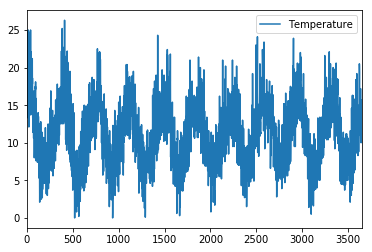

In [22]:
df.plot()

#### Descibe your dataframe

In [23]:
df.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [24]:
# Null Values?
df.isnull().sum()

Date           0
Temperature    0
dtype: int64

#### Drop null values

In [25]:
print(df.isnull().any(axis=1).sum())
df.dropna(inplace=True)
print(df.isnull().sum())

0
Date           0
Temperature    0
dtype: int64


#### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f72ce5994a8>]],
      dtype=object)

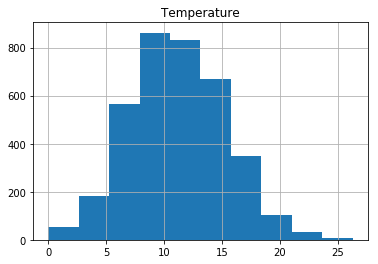

In [26]:
df.hist(bins=10)

#### Check the maximum and minimum values

In [27]:
# Scaled Data
print('Min', np.min(df))
print('Max', np.max(df))

Min Date           1981-01-01
Temperature             0
dtype: object
Max Date           1990-12-31
Temperature          26.3
dtype: object


In [28]:
# Data Cleansing
columns_to_keep = ['Temperature']
df = df[columns_to_keep]
df['Temperature'] = df['Temperature'].apply(lambda x: x*1000)
df.index.names = ['Month']
df.sort_index(inplace=True)
print('Total rows: {}'.format(len(df)))
df.head()

Total rows: 3650


,Temperature
Month,
0,20700.0
1,17900.0
2,18800.0
3,14600.0
4,15800.0


### Normalize the data

In [0]:
dataset = df.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

#### Check the maximum and minimum values of scaled data

In [30]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


#### Look into some of the scaled values

In [31]:
print(scaled[:10])

[[0.78707224]
 [0.68060837]
 [0.7148289 ]
 [0.55513308]
 [0.60076046]
 [0.60076046]
 [0.60076046]
 [0.66159696]
 [0.82889734]
 [0.76045627]]


### Split data into Training and Testing

In [32]:
#Create the model
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]

train: 2555
test: 1095


#### Print train and test size

In [33]:
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [35]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.78707224]
Y 1
0.6806083650190115
1
X 1 to 2
[0.68060837]
Y 2
0.714828897338403
2
X 2 to 3
[0.7148289]
Y 3
0.5551330798479087
3
X 3 to 4
[0.55513308]
Y 4
0.6007604562737643
4
X 4 to 5
[0.60076046]
Y 5
0.6007604562737643
5
X 5 to 6
[0.60076046]
Y 6
0.6007604562737643
6
X 6 to 7
[0.60076046]
Y 7
0.6615969581749049
7
X 7 to 8
[0.66159696]
Y 8
0.8288973384030418
8
X 8 to 9
[0.82889734]
Y 9
0.7604562737642586
9
X 9 to 10
[0.76045627]
Y 10
0.6159695817490495
10
X 10 to 11
[0.61596958]
Y 11
0.5057034220532319
11
X 11 to 12
[0.50570342]
Y 12
0.6349809885931559
12
X 12 to 13
[0.63498099]
Y 13
0.8174904942965779
13
X 13 to 14
[0.81749049]
Y 14
0.9505703422053232
14
X 14 to 15
[0.95057034]
Y 15
0.7870722433460076
15
X 15 to 16
[0.78707224]
Y 16
0.7832699619771863
16
X 16 to 17
[0.78326996]
Y 17
0.9429657794676806
17
X 17 to 18
[0.94296578]
Y 18
0.6730038022813688
18
X 18 to 19
[0.6730038]
Y 19
0.5893536121673004
19
X 19 to 20
[0.58935361]
Y 20
0.6920152091254753
20
X 20 to 21


#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [36]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 1, 1)
(1093, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [37]:
#The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.
#create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

W0707 10:09:14.147205 140132146112384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0707 10:09:14.213604 140132146112384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0707 10:09:14.224086 140132146112384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0707 10:09:14.493405 140132146112384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0707 10:09:14.708567 140132146112384 deprecation.py:323

Epoch 1/200
 - 4s - loss: 0.0302
Epoch 2/200
 - 4s - loss: 0.0147
Epoch 3/200
 - 4s - loss: 0.0131
Epoch 4/200
 - 3s - loss: 0.0121
Epoch 5/200
 - 3s - loss: 0.0115
Epoch 6/200
 - 4s - loss: 0.0113
Epoch 7/200
 - 3s - loss: 0.0111
Epoch 8/200
 - 3s - loss: 0.0109
Epoch 9/200
 - 4s - loss: 0.0107
Epoch 10/200
 - 3s - loss: 0.0107
Epoch 11/200
 - 3s - loss: 0.0102
Epoch 12/200
 - 4s - loss: 0.0103
Epoch 13/200
 - 4s - loss: 0.0101
Epoch 14/200
 - 4s - loss: 0.0102
Epoch 15/200
 - 4s - loss: 0.0102
Epoch 16/200
 - 3s - loss: 0.0102
Epoch 17/200
 - 4s - loss: 0.0101
Epoch 18/200
 - 4s - loss: 0.0101
Epoch 19/200
 - 4s - loss: 0.0101
Epoch 20/200
 - 4s - loss: 0.0102
Epoch 21/200
 - 4s - loss: 0.0101
Epoch 22/200
 - 3s - loss: 0.0101
Epoch 23/200
 - 4s - loss: 0.0102
Epoch 24/200
 - 4s - loss: 0.0101
Epoch 25/200
 - 3s - loss: 0.0101
Epoch 26/200
 - 3s - loss: 0.0102
Epoch 27/200
 - 4s - loss: 0.0101
Epoch 28/200
 - 3s - loss: 0.0102
Epoch 29/200
 - 4s - loss: 0.0101
Epoch 30/200
 - 4s - lo

### Summarize your model

In [38]:
model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/200
 - 4s - loss: 0.0101
Epoch 2/200
 - 3s - loss: 0.0101
Epoch 3/200
 - 4s - loss: 0.0101
Epoch 4/200
 - 4s - loss: 0.0101
Epoch 5/200
 - 4s - loss: 0.0101
Epoch 6/200
 - 4s - loss: 0.0101
Epoch 7/200
 - 3s - loss: 0.0101
Epoch 8/200
 - 3s - loss: 0.0101
Epoch 9/200
 - 4s - loss: 0.0101
Epoch 10/200
 - 3s - loss: 0.0100
Epoch 11/200
 - 4s - loss: 0.0101
Epoch 12/200
 - 4s - loss: 0.0101
Epoch 13/200
 - 3s - loss: 0.0101
Epoch 14/200
 - 4s - loss: 0.0101
Epoch 15/200
 - 4s - loss: 0.0101
Epoch 16/200
 - 4s - loss: 0.0101
Epoch 17/200
 - 4s - loss: 0.0101
Epoch 18/200
 - 4s - loss: 0.0101
Epoch 19/200
 - 4s - loss: 0.0101
Epoch 20/200
 - 4s - loss: 0.0101
Epoch 21/200
 - 4s - loss: 0.0100
Epoch 22/200
 - 4s - loss: 0.0100
Epoch 23/200
 - 4s - loss: 0.0101
Epoch 24/200
 - 4s - loss: 0.0101
Epoch 25/200
 - 4s - loss: 0.0101
Epoch 26/200
 - 4s - loss: 0.0100
Epoch 27/200
 - 4s - loss: 0.0100
Epoch 28/200
 - 4s - loss: 0.0101
Epoch 29/200
 - 4s - loss: 0.0101
Epoch 30/200
 - 4s - lo

### Train the model

In [0]:
#check the codes in above cells

## Make Predictions and Evaluate your model

In [39]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2704.19 RMSE
Test Score: 2609.64 RMSE


## Plot the results

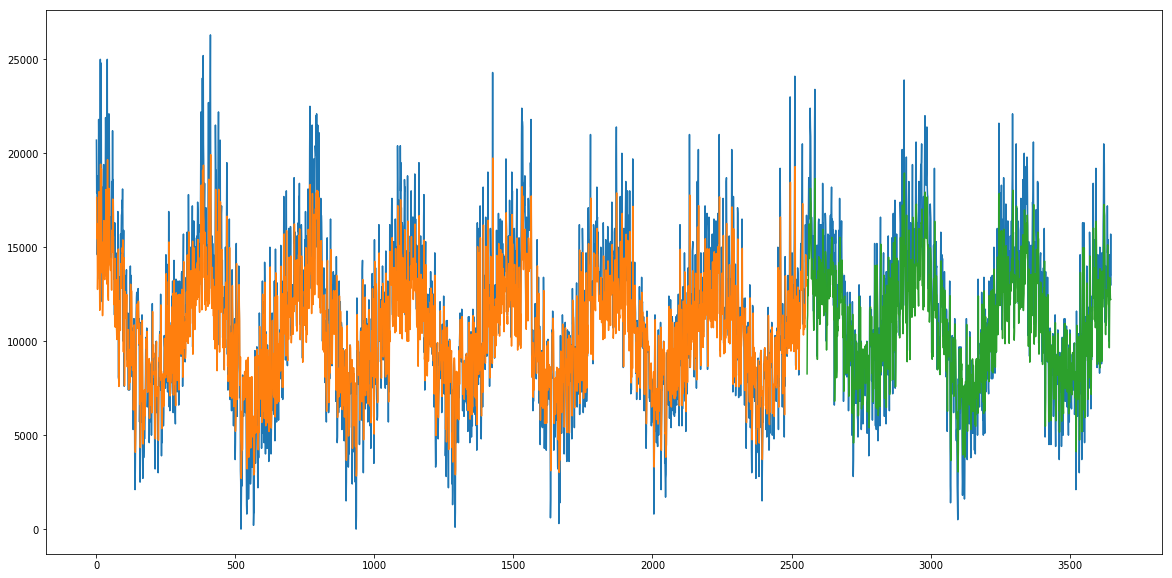

In [40]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()